In [1]:
from pathlib import Path

EVENT_DIR = Path("../data/raw/event_data/May 1, 2025")
EVENT_DIR



PosixPath('../data/raw/event_data/May 1, 2025')

In [2]:
event_files = list(EVENT_DIR.glob("*.json"))
len(event_files)

64

In [3]:
import json

all_events = []
for fp in event_files:
    with open(fp, "r") as f:
        all_events.extend(json.load(f))

len(all_events)

144541

In [4]:
import pandas as pd

df_all = pd.json_normalize(all_events)
df_all.shape

ModuleNotFoundError: No module named 'pandas'

In [ ]:
df_passes_all = df_all[df_all["possessionEvents.possessionEventType"] == "PA"].copy()

df_passes_all["is_completed"] = df_passes_all["possessionEvents.passOutcomeType"] == "C"

df_passes_all.shape

(66715, 262)

In [ ]:
pass_stats_all = (
    df_passes_all
    .groupby("possessionEvents.passerPlayerName")
    .agg(
        passes_attempted=("is_completed", "count"),
        passes_completed=("is_completed", "sum")
    )
    .assign(completion_rate=lambda x: x["passes_completed"] / x["passes_attempted"])
    .sort_values("passes_attempted", ascending=False)
)

pass_stats_all.head(15)


passes_attempted    360.000000
passes_completed    310.000000
completion_rate       0.861111
Name: Lionel Messi, dtype: float64

Center-backs and holding midfielders dominate pass volume, while attackers like Messi may attempt fewer but riskier passes.

In [ ]:
pass_stats_all.sort_values("completion_rate", ascending=False).head(15)

#Gives false results because of low number of passes attempted

,passes_attempted,passes_completed,completion_rate
possessionEvents.passerPlayerName,,,
Roan Wilson,5,5,1.0
Angel Correa,3,3,1.0
Gerson Torres,17,17,1.0
Ilias Chair,12,12,1.0
Kenneth Taylor,11,11,1.0
Georges-Kevin N'Koudou,9,9,1.0
Jan Bednarek,6,6,1.0
Badr Benoun,24,24,1.0
Djorkaeff Reasco,3,3,1.0


In [ ]:
high_volume_accurate = pass_stats_all[pass_stats_all["passes_attempted"] >= 100] \
    .sort_values("completion_rate", ascending=False)

high_volume_accurate.head(15)

#better results given more passes attempted

,passes_attempted,passes_completed,completion_rate
possessionEvents.passerPlayerName,,,
Leander Dendoncker,120,117,0.975000
Axel Witsel,179,172,0.960894
Marquinhos,362,346,0.955801
César Azpilicueta,177,169,0.954802
Jhegson Méndez,137,130,0.948905
Declan Rice,325,308,0.947692
John Stones,449,425,0.946548
Unai Simon,159,150,0.943396
Rodri,671,632,0.941878


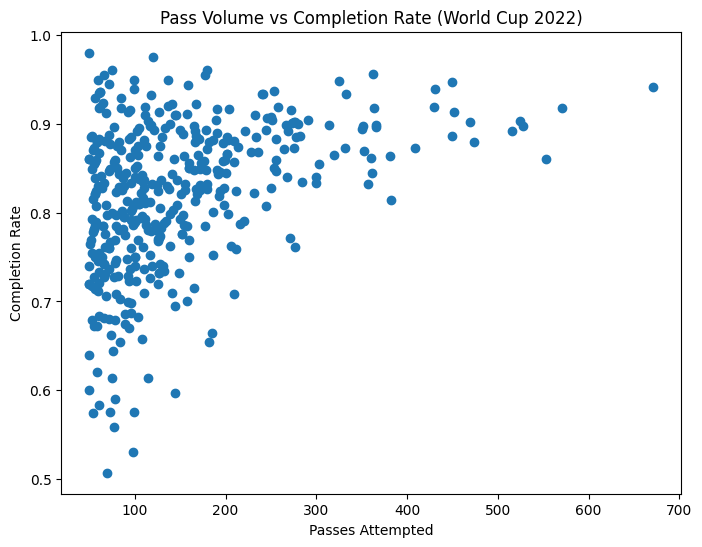

In [ ]:
import matplotlib.pyplot as plt

filtered = pass_stats_all[pass_stats_all["passes_attempted"] >= 50]

plt.figure(figsize=(8,6))
plt.scatter(
    filtered["passes_attempted"],
    filtered["completion_rate"]
)
plt.xlabel("Passes Attempted")
plt.ylabel("Completion Rate")
plt.title("Pass Volume vs Completion Rate (World Cup 2022)")
plt.show()

Players with very low pass volume show wide variation in completion rate, while players who attempt many passes tend to cluster at higher completion rates. This suggests that high-volume passers (often defenders and holding midfielders) are generally more reliable distributors.

In [ ]:
team_pass_stats = (
    df_passes_all
    .groupby("gameEvents.teamName")
    .agg(
        passes_attempted=("is_completed", "count"),
        passes_completed=("is_completed", "sum")
    )
    .assign(completion_rate=lambda x: x["passes_completed"] / x["passes_attempted"])
    .sort_values("passes_attempted", ascending=False)
)

team_pass_stats

In [ ]:
df_shots = df_all[df_all["possessionEvents.shotType"].notna()]
df_shots["possessionEvents.shooterPlayerName"].value_counts().head(15)

possessionEvents.shooterPlayerName
Lionel Messi           35
Kylian Mbappé          33
Lautaro Martinez       19
Olivier Giroud         18
Ivan Perisic           18
Cristiano Ronaldo      15
Dani Olmo              14
Serge Gnabry           14
Julian Alvarez         14
Harry Kane             12
Jamal Musiala          12
Neymar                 12
Robert Lewandowski     11
Hakim Ziyech           11
Aleksandar Mitrovic    11
Name: count, dtype: int64

In [ ]:
shots_by_player = (
    df_shots
    .groupby("possessionEvents.shooterPlayerName")
    .size()
    .rename("shots")
)

offensive_profile = pass_stats_all.join(shots_by_player, how="left")
offensive_profile["shots"] = offensive_profile["shots"].fillna(0)

offensive_profile.sort_values("shots", ascending=False).head(15)

,passes_attempted,passes_completed,completion_rate,shots
possessionEvents.passerPlayerName,,,,
Lionel Messi,360,310,0.861111,35.0
Kylian Mbappé,200,169,0.845000,33.0
Lautaro Martinez,67,49,0.731343,19.0
Olivier Giroud,76,49,0.644737,18.0
Ivan Perisic,271,209,0.771218,18.0
Cristiano Ronaldo,87,68,0.781609,15.0
Julian Alvarez,114,89,0.780702,14.0
Serge Gnabry,108,86,0.796296,14.0
Dani Olmo,178,151,0.848315,14.0


Star attackers like Messi and Mbappé combine high shot volume with substantial passing involvement, while traditional strikers such as Giroud and Kane take many shots but contribute fewer passes, indicating different attacking roles within teams.

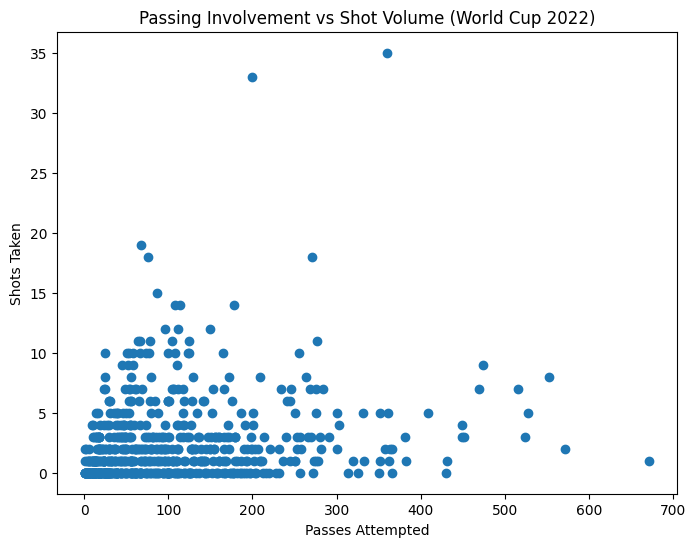

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(
    offensive_profile["passes_attempted"],
    offensive_profile["shots"]
)
plt.xlabel("Passes Attempted")
plt.ylabel("Shots Taken")
plt.title("Passing Involvement vs Shot Volume (World Cup 2022)")
plt.show()